In [1]:
#Libraries and directory
import os
import pandas as pd 
import numpy as np
import geopandas
import pickle
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from collections import defaultdict
from shapely.geometry import LineString, Point, Polygon, MultiPolygon
import statsmodels.api as sm
import scipy
from adjustText import adjust_text
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import StandardScaler
import palettable as pltt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, ListedColormap, LinearSegmentedColormap
from collections import Counter
import itertools

path = '/Users/Alice/Dropbox/PhD UNITO/Strava Project/data_and_notebook/'
os.chdir(path)

#Set data visualisation parameters
plt.rcParams.update({'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'})
plt.rc('font', family='Arial') 

colors = [(169/255, 230/255, 85/255), (116/255, 88/255, 209/255)]
my_cmap = LinearSegmentedColormap.from_list("Custom", colors, N=100)
my_col1=(0.531, 0.680, 0.415)
my_col2=my_cmap(0.7)
my_col3=(0.322, 0.29, 0.616)

color={'Benelux': my_col2 , 'UK': my_col2,'US': my_col2, 'Italy': my_col2}

### Import data

In [5]:
#Import dataset
df=pd.read_csv(path+'final data/City_level_final_dataset.csv', sep=',')
# 1) Exclude if boundary is not ghs boundary
df=df[df['boundary']=='ghs']
# 2) Keep only 'geography of interest'
df=df[df['macro_areas']!='Rest of the World']
# Keep only relevant indicators
df=df[['country', 'city','gender_ratio','macro_areas','share_pop_green', 
      'pct_open_space','built_up_area_percap', 'night_light_em', 'pm25_concentration',
      'area', 'pop_density', 'gdp_per_pers','gender_equality_index','k_avg', 'grade_mean', 
      'orientation_order', 'prop_3way', 'straightness','bike_lane_area_prop','maxspeed_area_prop']]
#Generate variable for model descriptions
df['macro_areas1']=''
df.loc[df['macro_areas']=='US', 'macro_areas1']='US'
df.loc[(df['macro_areas']!='US'), 'macro_areas1']='Europe'
df.head(5)

### Define different models (model is always linear estimated via OLS, but change approach to variables standardisation)
-  1) Unique model, Selected countries=['US', 'UK', 'Italy', 'Benelux'] with the latter including 'UK', 'Italy', 'Benelux', 'Rest of Europe', both inputs and target standardised across the entire sample, include dummies for area ['US', 'UK', 'Italy', 'Benelux'];
-  2) Unique model, Selected countries=['US', 'Europe'] with the latter including 'UK', 'Italy', 'Benelux', 'Rest of Europe', both inputs and target standardised across the entire sample, include dummies for area ['US', 'Europe'];
-  3) Unique model, Selected countries=['US', 'Europe'] with the latter including 'UK', 'Italy', 'Benelux', 'Rest of Europe', only target standardised by macro-area ['US', 'Europe'], inputs standardized across entire sample;
-  4) Unique model, Selected countries=['US', 'Europe'] with the latter including 'UK', 'Italy', 'Benelux', 'Rest of Europe', both inputs and target standardised by macro-area ['US', 'Europe']

In [76]:
#Models definition in term of variable standardisation
model_parm={1:{'macro_areas_var':'macro_areas', 'macro_areas_val':['US', 'UK', 'Italy', 'Benelux'], 'input_stand_var':'entire_sample' ,'target_stand_var':'entire_sample', 'dummies':'yes'},
            2:{'macro_areas_var':'macro_areas1', 'macro_areas_val':['US', 'Europe'], 'input_stand_var':'entire_sample' ,'target_stand_var':'entire_sample', 'dummies':'yes'},
            3:{'macro_areas_var':'macro_areas1', 'macro_areas_val':['US', 'Europe'], 'input_stand_var':'entire_sample' ,'target_stand_var':'macro_areas1', 'dummies':'no'},
            4:{'macro_areas_var':'macro_areas1', 'macro_areas_val':['US', 'Europe'], 'input_stand_var':'macro_areas1' ,'target_stand_var':'macro_areas1', 'dummies':'no'}}
        
original_cols=['gender_ratio','share_pop_green', 
      'pct_open_space','built_up_area_percap', 'night_light_em', 'pm25_concentration',
      'area', 'pop_density', 'gdp_per_pers','gender_equality_index','k_avg', 'grade_mean', #
      'orientation_order', 'prop_3way', 'straightness','bike_lane_area_prop','maxspeed_area_prop']

#Dictionary to rename each variable nicely in plots
col_name_dict={'gender_ratio': r'$\sigma_{c}$',
      'avg_precipitation':'precipitation', 'avg_temperature':'temperature',
      'share_pop_green':'share green', 'pct_open_space':'open space', 
      'built_up_area_percap':'built area', 'night_light_em':'night-light emissions', 
      'pm25_concentration':'pm 2.5',
      'area':'area', 'pop_density':'population', 'gdp_per_pers':'GDP','gender_equality_index':'GEI',
      'k_avg':'degree', 'grade_mean':'grade', 
      'orientation_order':'orientation', 'prop_3way':'3-way crosses', 'straightness':'straightness',
      'bike_lane_area_prop':'bike lanes','maxspeed_area_prop':'speed limit', 'Benelux':'Benelux', 'US':'US', 'UK':'UK' }


### Define functions for:
- Data standardization
- Extensive search for variable selection
- Estimation pipeline

In [77]:
#Write pipeline for data standardization
def pipeline_data_selection_standardization(original_df,model,model_parameter , original_columns):
   
    data=original_df.copy()
    #Countries exclusions
    data=data[data[model_parameter[model]['macro_areas_var']].isin(model_parameter[model]['macro_areas_val'])]
    
    #Variables standardization
    ##Inputs
    scalerx = StandardScaler(with_std=True)
    for i in list(set(original_columns)-set(['gender_ratio'])):
        if model_parameter[model]['input_stand_var']!='entire_sample':
            for macro_area in list(data[model_parameter[model]['input_stand_var']].unique()):
                data.loc[data[model_parameter[model]['input_stand_var']]==macro_area, i]  = scalerx.fit_transform(data.loc[data[model_parameter[model]['input_stand_var']]==macro_area,i].to_numpy().reshape(-1,1))
        else:
            data[i]  = scalerx.fit_transform(data[i].to_numpy().reshape(-1,1))

    ##Target
    scalery = StandardScaler(with_std=True)
    if model_parameter[model]['target_stand_var']!='entire_sample':
        for macro_area in list(data[model_parameter[model]['target_stand_var']].unique()):
            data.loc[data[model_parameter[model]['target_stand_var']]==macro_area, 'gender_ratio']  = scalery.fit_transform(data.loc[data[model_parameter[model]['target_stand_var']]==macro_area, 'gender_ratio'].to_numpy().reshape(-1,1))
    else:
        data['gender_ratio']  = scalery.fit_transform(data['gender_ratio'].to_numpy().reshape(-1,1))        
    
    col_to_export=original_columns.copy()
    col_to_export.extend(['macro_areas1', 'macro_areas', 'city', 'country'])
    return data[col_to_export], scalery

# Define pipeline to perform exthensive search for variable selection 
def pipeline_exthensive_search(standardized_data, model, model_parameter, original_columns):
               
    original_columns=list(set(original_columns)-set(['gender_ratio']))
    if model==1:
        original_columns=list(set(original_columns)-set(['gender_equality_index']))  #Excluded from model 1 due to influence on countries dummies

    add_col=[]
    if model_parameter[model]['dummies']=='yes':
        for macro_area in list(standardized_data[model_parameter[model]['macro_areas_var']].unique()):
            add_col.append(macro_area)
            standardized_data[macro_area]=0
            standardized_data.loc[standardized_data[model_parameter[model]['macro_areas_var']]==macro_area, macro_area]=1       
    
    combinations = []
    for i in range(1, len(original_columns)+1):
        for c in itertools.combinations(original_columns, i):
            combinations.append(list(c))

        
    results = {}
    for ind,c in enumerate(combinations):
        c=list(c)
        c.extend(add_col[1:])
        if len(c)<len(standardized_data):
            X = standardized_data[c]
            y = standardized_data['gender_ratio']
            m = sm.OLS(y, X.astype(float)).fit()
            label = "|".join(c)
            results[label] = {
                    'aic': m.aic,
                    'bic':m.bic,
                    'mse':m.mse_total,
                    'r':m.rsquared_adj
                }
    pickle.dump(results, open('Outputs/DataStorageResults/FeaturesSelection_BruteForce_Final_model'+str(model)+'_no prep_no_ temp.pickle', 'wb'))
    list_key=list(results.keys())
    list_key=sorted(list_key, key=lambda x: (results[x]['r']))      
    return results


#Write pipeline for model estimation
def pipeline_estimation(standardized_data,model, dic_extensive_search,model_parameter):

    if model_parameter[model]['dummies']=='yes':
        for macro_area in list(standardized_data[model_parameter[model]['macro_areas_var']].unique()):
            standardized_data[macro_area]=0
            standardized_data.loc[standardized_data[model_parameter[model]['macro_areas_var']]==macro_area, macro_area]=1       

    
    #Read results from extensive search pipeline. Select min aic
    c = sorted(dic_extensive_search.items(), key=lambda item: item[1]['aic'])[1][0]
    selected_features=c.split('|')
    
    #Model estimation
    X = standardized_data[selected_features]
    y = standardized_data['gender_ratio']

    # final OLS regression
    final_model = sm.OLS(y, X.astype(float)).fit()
    p = final_model.params
    
    actual_fitted=np.column_stack((y, final_model.fittedvalues))

    results_table = pd.DataFrame([final_model.params, final_model.pvalues, final_model.bse]).T.rename(columns={0: "parameters", 1: 'p values', 2: 'std'},
                                                                          index={0: 'constant', 1: selected_features[0], 2: selected_features[1], 3: selected_features[2], 4: selected_features[3]})#, 5: cols[4], 6: cols[5]})
    conf_int = final_model.conf_int()
    results_table['[0.025'] = conf_int.iloc[:,0]
    results_table['0.975]'] = conf_int.iloc[:,1]
    results_table['significance']=results_table.apply(lambda x: 1 if  x['p values']<0.05 else 0 , axis=1)       
    
    return actual_fitted,results_table, final_model.rsquared_adj

#### Run full pipeline for all 4 models

In [78]:
models_comparison=[]
for model in [1, 2, 3, 4]:
    print(model)
    data_standardized, scaler_y=pipeline_data_selection_standardization(df, model,model_parm , original_cols)
    selected_vars=pipeline_exthensive_search(data_standardized, model,model_parm , original_cols)
    dic=open('Outputs/DataStorageResults/FeaturesSelection_BruteForce_Final_model'+str(model)+'_no prep_no_ temp.pickle', 'rb')
    dic_extensive_search=pickle.load(dic)
    dic.close()
    actual_fitted_values, results_table, adj_r_squared=pipeline_estimation(data_standardized, model, dic_extensive_search,model_parm)
    models_comparison.append([actual_fitted_values, results_table, adj_r_squared])


1
2
3
4


### Plot models comparison

1
2
3
4


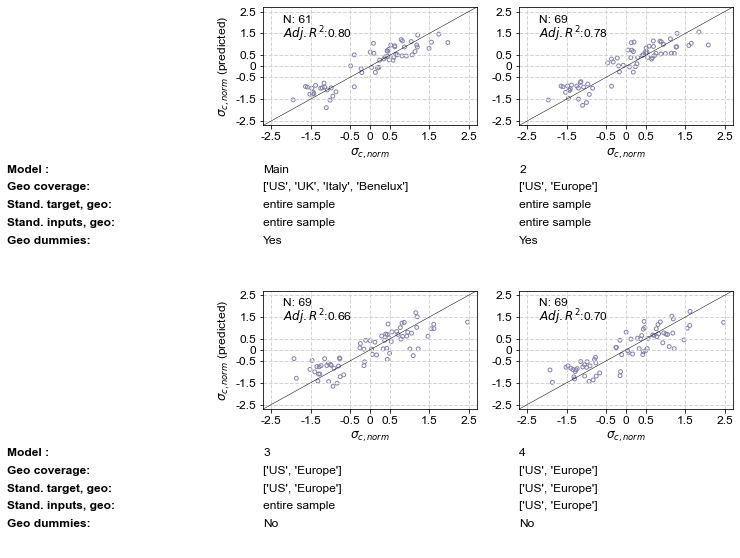

In [79]:
#Plot actual vs fitted values and information on characteristics of each model
fig=plt.figure(figsize=(13,10))
ax1 = plt.subplot(4,3, 4)
ax1.axis('off')
ax1.text(0, 0.8 ,r"Model :", weight='bold', size=12)
ax1.text(0, 0.65,r"Geo coverage:" , weight='bold', size=12)
ax1.text(0, 0.50,r"Stand. target, geo:", weight='bold', size=12)
ax1.text(0, 0.35,r"Stand. inputs, geo:", weight='bold', size=12)
ax1.text(0, 0.20,r"Geo dummies:", weight='bold', size=12)
ax1 = plt.subplot(4,3, 10)
ax1.axis('off')
ax1.text(0, 0.8 ,r"Model :", weight='bold', size=12)
ax1.text(0, 0.65,r"Geo coverage:" , weight='bold', size=12)
ax1.text(0, 0.50,r"Stand. target, geo:", weight='bold', size=12)
ax1.text(0, 0.35,r"Stand. inputs, geo:", weight='bold', size=12)
ax1.text(0, 0.20,r"Geo dummies:", weight='bold', size=12)

for model in [1,2]:
    print(model)
    actual_fitted_values, results_table, adj_r_squared=[models_comparison[model-1][0],models_comparison[model-1][1],models_comparison[model-1][2]]
    ax0 = plt.subplot(4,3, model+1)
    ax0.plot([-2.7, 2.7], [-2.7, 2.7], color='black', linewidth=0.5)
    ax0.scatter(actual_fitted_values[:,0], actual_fitted_values[:,1], marker= 'o', color='None', s= 15, edgecolors= my_col2, linewidth=1)
    ax0.text(-2.2, 2,r"N: %i" %(actual_fitted_values.shape[0]) , size=12)
    ax0.text(-2.2, 1.3 ,r"$Adj. R^{2}$:%0.2f" %(adj_r_squared), size=12)
    ax0.set_xlabel(r'$\sigma_{c,norm}$', size=12)
    ax0.set_xticks([-2.5,  -1.5, -0.5, 0, 0.5,  1.5, 2.5])
    ax0.set_xticklabels([-2.5,  -1.5, -0.5, 0, 0.5,  1.5, 2.5], size=12)
    ax0.set_yticks([-2.5,  -1.5, -0.5, 0, 0.5,  1.5, 2.5])
    ax0.set_yticklabels([-2.5,  -1.5, -0.5, 0, 0.5,  1.5, 2.5], size=12)
    if model==1:
        ax0.set_ylabel(r'$\sigma_{c,norm}$ (predicted)', size=12)
    #plotting the identity line
    ax0.set_xlim([-2.7, 2.7])
    ax0.set_ylim([-2.7, 2.7])
    ax0.grid(b=True, which='major', axis='both', color='lightgrey', linestyle='--', linewidth=1) 
    
    ax1 = plt.subplot(4,3, model+4)
    ax1.axis('off')
    if model!=1:
        ax1.text(0, 0.8 ,r"%i" %(model), size=12)
    else:
        ax1.text(0, 0.8 ,"Main", size=12)
    ax1.text(0, 0.65,r"%s" %(model_parm[model]['macro_areas_val']) , size=12)
    if model_parm[model]['target_stand_var']!='entire_sample':
        ax1.text(0, 0.5,r"%s" %(model_parm[model]['macro_areas_val']) , size=12)
    else:
        ax1.text(0, 0.5,r"entire sample" %(model_parm[model]['macro_areas_val']) , size=12)
    if model_parm[model]['input_stand_var']!='entire_sample':
        ax1.text(0, 0.35,r"%s" %(model_parm[model]['macro_areas_val']) , size=12)
    else:
        ax1.text(0, 0.35,r"entire sample" %(model_parm[model]['macro_areas_val']) , size=12)
    ax1.text(0, 0.20,r"%s" %(model_parm[model]['dummies'].capitalize()) , size=12)
    
for model in [3,4]:
    print(model)
    actual_fitted_values, results_table, adj_r_squared=actual_fitted_values, results_table, adj_r_squared=[models_comparison[model-1][0],models_comparison[model-1][1],models_comparison[model-1][2]]
    ax0 = plt.subplot(4,3, model+5)
    ax0.plot([-2.7, 2.7], [-2.7, 2.7], color='black', linewidth=0.5)
    ax0.scatter(actual_fitted_values[:,0], actual_fitted_values[:,1], marker= 'o', color='None', s= 15, edgecolors= my_col2, linewidth=1)
    ax0.text(-2.2, 2,r"N: %i" %(actual_fitted_values.shape[0]) , size=12)
    ax0.text(-2.2, 1.3 ,r"$Adj. R^{2}$:%0.2f" %(adj_r_squared), size=12)
    ax0.set_xlabel(r'$\sigma_{c,norm}$', size=12)
    ax0.set_xticks([-2.5,  -1.5, -0.5, 0, 0.5,  1.5, 2.5])
    ax0.set_xticklabels([-2.5,  -1.5, -0.5, 0, 0.5,  1.5, 2.5], size=12)
    ax0.set_yticks([-2.5,  -1.5, -0.5, 0, 0.5,  1.5, 2.5])
    ax0.set_yticklabels([-2.5,  -1.5, -0.5, 0, 0.5,  1.5, 2.5], size=12)
    ax0.set_xlabel(r'$\sigma_{c,norm}$', size=12)
    if model==3:
        ax0.set_ylabel(r'$\sigma_{c,norm}$ (predicted)', size=12)
    #plotting the identity line
    ax0.set_xlim([-2.7, 2.7])
    ax0.set_ylim([-2.7, 2.7])
    ax0.grid(b=True, which='major', axis='both', color='lightgrey', linestyle='--', linewidth=1) 
    
    ax1 = plt.subplot(4,3, model+8)
    ax1.axis('off')
    ax1.text(0, 0.8 ,r"%i" %(model), size=12)
    ax1.text(0, 0.65,r"%s" %(model_parm[model]['macro_areas_val']) , size=12)
    if model_parm[model]['target_stand_var']!='entire_sample':
        ax1.text(0, 0.5,r"%s" %(model_parm[model]['macro_areas_val']) , size=12)
    else:
        ax1.text(0, 0.5,r"entire sample" %(model_parm[model]['macro_areas_val']) , size=12)
    if model_parm[model]['input_stand_var']!='entire_sample':
        ax1.text(0, 0.35,r"%s" %(model_parm[model]['macro_areas_val']) , size=12)
    else:
        ax1.text(0, 0.35,r"entire sample" %(model_parm[model]['macro_areas_val']) , size=12)
    ax1.text(0, 0.20,r"%s" %(model_parm[model]['dummies'].capitalize()) , size=12)
    
fig.savefig('Outputs/Figures/Raw/FigS4_1.pdf', dpi=300, facecolor='white',bbox_inches = "tight")

In [80]:
# Preparatory stage to plot coefficients matrix to compare results across models 
for model in [1,2,3,4]:
    tmp=models_comparison[model-1][1]
    if model==1:
        results_comparison=tmp['parameters'].copy()
    else:
        results_comparison=pd.merge(results_comparison, tmp['parameters'], left_index=True, right_index=True, how='outer', suffixes=('', '_'+str(model)))
results_comparison.rename(columns={'parameters':'parameters_1'}, inplace=True)

for model in [1,2,3,4]:
    tmp=models_comparison[model-1][1]
    if model==1:
        results_comparison_significance=tmp['significance'].copy()
    else:
        results_comparison_significance=pd.merge(results_comparison_significance, tmp['significance'], left_index=True, right_index=True, how='outer', suffixes=('', '_'+str(model)))
results_comparison_significance.rename(columns={'significance':'significance_1'}, inplace=True)

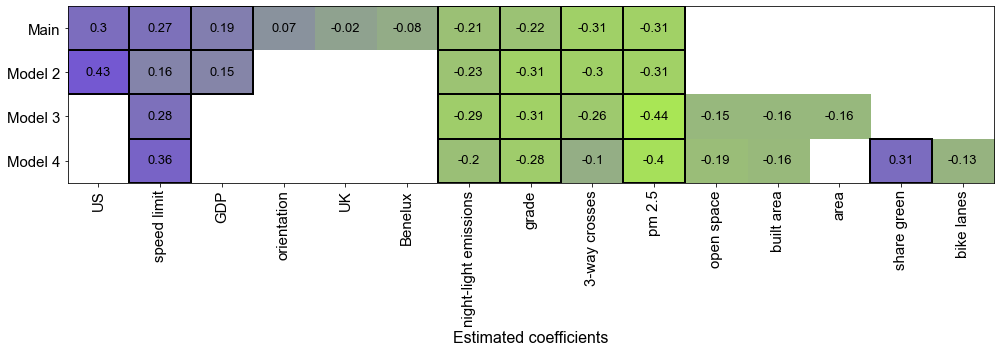

In [81]:
#Plot coefficient matrix
results_comparison.sort_values(by=['parameters_1', 'parameters_2', 'parameters_3', 'parameters_4'], ascending=False, inplace=True)
results_comparison_significance=results_comparison_significance.fillna(0).reindex(results_comparison.index)
mat = results_comparison.values
annotations = results_comparison.round(2).astype(str)
annotations[np.isnan(results_comparison)] = ""


fig=plt.figure(figsize=(14,5))
ax=plt.subplot(1,1,1)
ax.imshow(mat.transpose(), cmap=my_cmap, aspect='auto')
for indj,j in enumerate(list(results_comparison.index)):
    for indi,i in enumerate(list(results_comparison.columns)):
        text = ax.text(indj, indi, annotations.transpose().at[i, j],
                       ha="center", va="center", color="black", size=13)
ax.set_yticks(range(len(list(results_comparison.columns))))
ax.set_yticklabels(['Main', 'Model 2', 'Model 3', 'Model 4'], size=15)
ax.set_xticks(range(len(list(results_comparison.index))))
results_comparison['ind']=results_comparison.index
results_comparison['label']=results_comparison['ind'].apply(lambda x: col_name_dict[x])
ax.set_xticklabels(results_comparison['label'], rotation=90,size=15)
#ax.set_xticklabels(['US', 'speed_limit', 'GDP', 'UK', 'Benelux', 'light_emission', 'grade', '3_ways_crosses', 'pm2.5', 'gender_equality_index', 'open_space', 'area', 'built_area','share_green', 'orientation', 'bike_lanes'], rotation=90,size=15)
ax.set_xlabel('Estimated coefficients', size=16)
plt.tight_layout()

#Add grid line around significant coefficient at 5%
def rect(pos):
    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=2)
    plt.gca().add_patch(r)

y,x = np.meshgrid(np.arange(results_comparison_significance.shape[1]),np.arange(results_comparison_significance.shape[0]))
m = np.c_[x[results_comparison_significance.astype(bool)],y[results_comparison_significance.astype(bool)]]
for pos in m:
    rect(pos)
plt.savefig('Outputs/Figures/Raw/FigS4_2.pdf', dpi=300, facecolor='white')

### Re-run preferred model

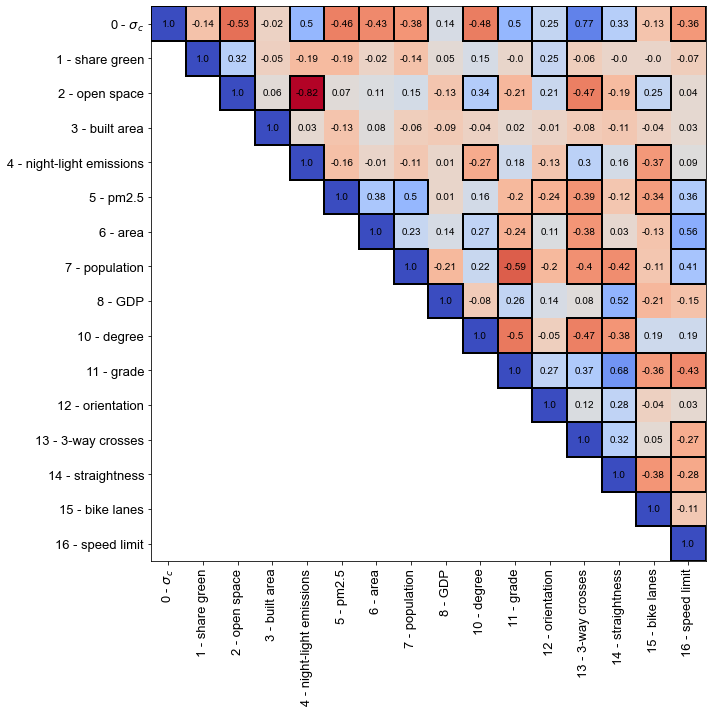

In [82]:
cols_name=[r'0 - $\sigma_{c}$',
      '1 - share green', '2 - open space', 
      '3 - built area', '4 - night-light emissions', 
      '5 - pm2.5',
      '6 - area', '7 - population', '8 - GDP',
      '10 - degree', '11 - grade', 
      '12 - orientation', '13 - 3-way crosses', '14 - straightness',
      '15 - bike lanes','16 - speed limit' ]

results_table.sort_values(by='parameters', inplace=True)
results_table=results_table.reset_index()
results_table['label']=results_table.apply(lambda x:col_name_dict[x['index']], axis=1)
results_table['param_1']=results_table.apply(lambda x: x['parameters'] if x['significance']==1 else np.nan, axis=1)
results_table['param_0']=results_table.apply(lambda x: x['parameters'] if x['significance']==0 else np.nan, axis=1)

cm=np.zeros((len(cols_name),len(cols_name)))
cm_pval=np.zeros((len(cols_name),len(cols_name)))
for i in range(16):
    for j in range(16):
        cm[i,j]=scipy.stats.pearsonr(data_standardized[list(set(original_cols)-set(['gender_equality_index']))[i]], data_standardized[list(set(original_cols)-set(['gender_equality_index']))[j]])[0]
        if scipy.stats.pearsonr(data_standardized[list(set(original_cols)-set(['gender_equality_index']))[i]], data_standardized[list(set(original_cols)-set(['gender_equality_index']))[j]])[1]<0.05:
            if i<=j:
                cm_pval[i,j]=1
            else:
                cm_pval[i,j]=0
        else:
            cm_pval[i,j]=0
fig=plt.figure(figsize=(10,10))
ax=plt.subplot(1,1,1)
mask =  np.tri(cm.shape[0], k=-1)
cm = np.ma.array(cm, mask=mask)
ax.imshow(cm, cmap='coolwarm_r', aspect='auto')
for indi in range(16):
    for indj in range(16):
        text = ax.text(indj, indi, np.around(cm[indi,indj], 2),
                       ha="center", va="center", color="black")
ax.set_xticks(range(len(cols_name)))
ax.set_xticklabels(cols_name,rotation=90, size=13)
ax.set_yticks(range(len(cols_name)))
ax.set_yticklabels(cols_name, size=13)
plt.tight_layout()

#Add grid line around significant coefficient at 5%
def rect(pos):
    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=2)
    plt.gca().add_patch(r)

x,y = np.meshgrid(np.arange(cm_pval.shape[1]),np.arange(cm_pval.shape[0]))
m = np.c_[x[cm_pval.astype(bool)],y[cm_pval.astype(bool)]]
for pos in m:
    rect(pos)

fig.savefig('Outputs/Figures/Raw/FigS3.pdf', bbox_inches="tight", facecolor="white", dpi=300) 

In [83]:
#Set preferred model
model=1
from scipy.stats import norm as normal

#Data standardization (following rules defined in preferred model)
data_standardized, scalar_y=pipeline_data_selection_standardization(df, model,model_parm , original_cols)
#Import info on variables from extensive search
dic=open('Outputs/DataStorageResults/FeaturesSelection_BruteForce_Final_model'+str(model)+'_no prep_no_ temp.pickle', 'rb')
dic_extensive_search=pickle.load(dic)
dic.close()
#Fit model & export required data
actual_fitted_values, results_table, adj_r_squared=[models_comparison[model-1][0],models_comparison[model-1][1],models_comparison[model-1][2]]

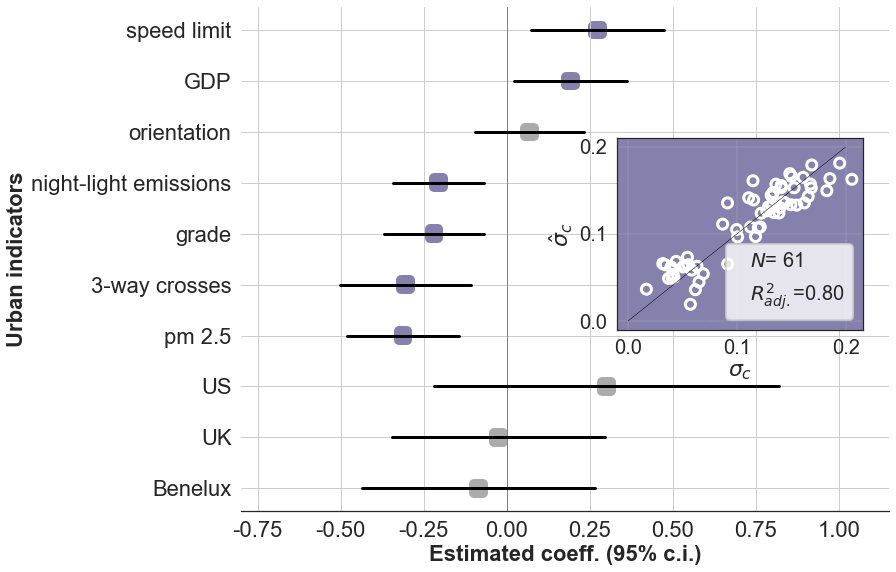

In [84]:
### Plot summary figure for preferred model
fig=plt.figure(figsize=(9,7))  

cols_name=[r'0 - $\sigma_{c}$',
      '1 - share green', '2 - open space', 
      '3 - built area', '4 - night-light emissions', 
      '5 - pm2.5',
      '6 - area', '7 - population', '8 - GDP','9 - GEI',
      '10 - degree', '11 - grade', 
      '12 - orientation', '13 - 3-way crosses', '14 - straightness',
      '15 - bike lanes','16 - speed limit' ]

results_table=results_table.reset_index(drop=False)
results_table['label']=results_table.apply(lambda x:col_name_dict[x['index']], axis=1)
results_table['dummy_loc']=2
results_table.loc[(results_table.label=='Benelux') | (results_table.label=='UK') | (results_table.label=='US'), 'dummy_loc']=1
results_table['param_1']=results_table.apply(lambda x: x['parameters'] if x['significance']==1 else np.nan, axis=1)
results_table['param_0']=results_table.apply(lambda x: x['parameters'] if x['significance']==0 else np.nan, axis=1)
results_table.sort_values(by=[ 'dummy_loc','parameters'], inplace=True)
results_table=results_table.reset_index(drop='True')
results_table['ind']=results_table.index

cm = np.corrcoef(data_standardized[original_cols].values.T)
# Generate a mask for the upper triangle
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
mask = np.triu(np.ones_like(cm, dtype=bool))
sns.set(font_scale=2)
sns.set_theme(style="white")

ax2 = fig.add_axes([0, 0., 1, 1])
ax2.set_yticks(np.linspace(0,len(results_table)-1,len(results_table)))
ax2.set_yticklabels(results_table.label, size=22)
ax2.set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25])
ax2.set_xticklabels([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25],size=22)
ax2.set_xlim([-0.8, 1.15])
ax2.grid(b=None, which='both', axis='both')
#Add vertical line at 0
ax2.axvline(0, color='gray', lw=1)
#Add confidence intervals bar:
for ind in list(results_table.ind):
    ax2.plot([results_table.at[ind,'[0.025'],results_table.at[ind,'0.975]']], [ind,ind], color='black', linewidth=3)
ax2.scatter(results_table.param_1,results_table.index, marker='s', s=75,color='None',edgecolor=my_col2, linewidth=10, zorder=0)
ax2.scatter(results_table.param_0,results_table.index, marker='s', s=75,color='None',edgecolor='#ababab', linewidth=10, zorder=0)
ax2.set_xlabel('Estimated coeff. (95% c.i.)', weight='bold', size=22)
ax2.set_ylabel('Urban indicators', weight='bold', rotation=90, size=22)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax1=fig.add_axes([0.58, 0.36, 0.38, 0.38])
ax1.plot([0.0, 0.2], [0.0, 0.2], color='black', linewidth=0.5)
ax1.scatter(scalar_y.inverse_transform(actual_fitted_values[:,0]), scalar_y.inverse_transform(actual_fitted_values[:,1]), marker= 'o', color='None', s= 100, edgecolors='white',  linewidth=3)
ax1.axvline([0.03], color='w', linewidth=0, label=r"$N$= %i" %(actual_fitted_values.shape[0]) )
ax1.axvline([0.03], color='w', linewidth=0, label=r"$R^{2}_{adj.}$=%0.2f" %(adj_r_squared) )
legend=ax1.legend(loc='best', fontsize=20, frameon=True , handlelength=0)
legend.get_frame().set_linewidth(2)
ax1.set_xticks([0.0,  0.1,  0.2])
ax1.set_xticklabels([0.0,  0.1,  0.2], size=20)
ax1.set_yticks([0.0,  0.1,  0.2])
ax1.set_yticklabels([0.0,  0.1,  0.2], size=20)
ax1.set_xlabel(r'$\sigma_{c}$', size=22, weight='bold')
ax1.set_ylabel(r'$\hat{\sigma}_{c}$ ', size=22, weight='bold')
ax1.grid(b=True, which='major', axis='both', color='lightgrey', linestyle='--', linewidth=0.3) 
ax1.set_facecolor(my_col2)
fig.savefig('Outputs/Figures/Raw/Fig3.pdf', bbox_inches="tight", facecolor="white", dpi=300) 

### Figures and descriptives

In [2]:
#Import dataset
df=pd.read_csv(path+'final data/City_level_final_dataset.csv', sep=',')
# 1) Exclude if boudndary is not ghs boundary
df=df[df['boundary']=='ghs']
# 2) Keep only 'geography of interest'
df=df[df['macro_areas']!='Rest of the World']
#Generate variable for model descriptions
df['macro_areas1']=''
df.loc[df['macro_areas']=='US', 'macro_areas1']='US'
df.loc[(df['macro_areas']!='US'), 'macro_areas1']='Europe'
df.head(5)

,city,country,macro_areas,gender_ratio,bike_lane_area_prop,maxspeed_area_prop,circuity,elev_iqr,pagerank_max,k_avg,...,avg_temperature,share_pop_green,pct_open_space,greenness_total,greenness_average,latitudine,longitudine,gender_equality_index,boundary,macro_areas1
0,Taranto,Italy,Italy,0.016924,0.009729,0.079954,1.065992,9.00,0.001990,2.987867,...,17.628122,0.030133,44.29,55.902041,0.227354,40.487062,17.217146,0.707,ghs,Europe
2,Rome,Italy,Italy,0.031974,0.039590,0.026502,1.065008,35.00,0.000151,2.859056,...,16.286262,0.165457,50.53,481.322708,0.402501,41.897154,12.532313,0.707,ghs,Europe
3,Catania,Italy,Italy,0.034221,0.013663,0.008347,1.060221,265.00,0.000474,2.781315,...,17.303404,0.122431,49.37,108.480645,0.350604,37.534481,15.071530,0.707,ghs,Europe
4,Prato,Italy,Italy,0.037279,0.201752,0.028904,1.065160,16.00,0.000861,2.785148,...,13.799587,0.257165,45.38,70.585350,0.381205,43.869044,11.106928,0.707,ghs,Europe
5,Reggio Emilia,Italy,Italy,0.039592,0.558513,0.096888,1.062282,12.25,0.001196,2.596370,...,14.102024,0.305351,48.19,24.140420,0.433645,44.692327,10.626222,0.707,ghs,Europe


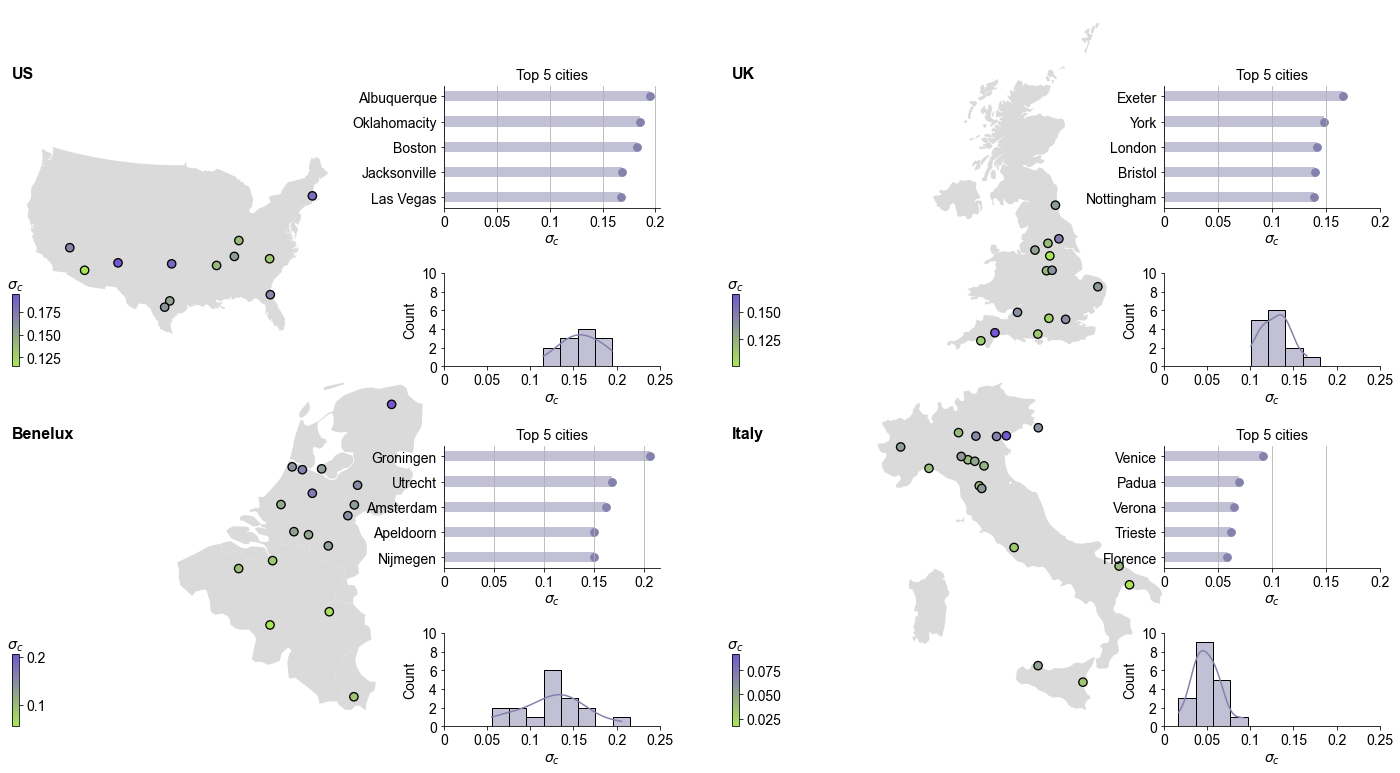

In [70]:
df['geometry']=df.apply(lambda x: Point(x['longitudine'], x['latitudine']), axis=1)
gdf=geopandas.GeoDataFrame(df, geometry='geometry', crs='WGS84')

#Import shapefile for country-shapes
countries=geopandas.read_file(path+'others/UIA_World_Countries_Boundaries/World_Countries__Generalized_.shp')
US_bounding=[Polygon(((-171.791110603, 18.91619),(-171.791110603, 71.3577635769),(-66.96466, 71.3577635769),(-66.96466, 18.91619),(-171.791110603, 18.91619)))]
US_bounding=pd.DataFrame(US_bounding)
US_bounding.rename(columns={0:'geometry'}, inplace=True)
US_bounding=geopandas.GeoDataFrame(US_bounding, geometry='geometry', crs='WGS84')
countries.loc[countries.ISO=='US', 'geometry']=geopandas.overlay(countries[countries.ISO=='US'],US_bounding, how='intersection' ).geometry[0][0]

pos=[[0,0.5, 0.3,0.5,0.3,0.72,],
    [0.5,0.5, 0.8,0.5,0.8,0.72,],
    [0,0, 0.3,0,0.3,0.22,],
    [0.5,0, 0.8,0,0.8,0.22,]]

country_iso={'US':['US'], 'UK':['GB'], 'Benelux':['LU','BE','NL'], 'Italy':['IT']}

fig=plt.figure(figsize=(20,10))
vmin = gdf.gender_ratio.min()
vmax = gdf.gender_ratio.max()
for ind,i in enumerate(['US', 'UK', 'Benelux', 'Italy']):
    #Plot map
    vmin = gdf[gdf['macro_areas']==i].gender_ratio.min()
    vmax = gdf[gdf['macro_areas']==i].gender_ratio.max()
    fig.text(pos[ind][0],pos[ind][1]+0.4, i, weight='bold', size=16)
    if i=='US':
        ax=fig.add_axes([pos[ind][0],pos[ind][1], 0.23, 0.35])
    else:
        ax=fig.add_axes([pos[ind][0],pos[ind][1], 0.4, 0.5])
    if i!='US':
        countries[countries['ISO'].isin(country_iso[i])].to_crs('epsg:3035').plot(color='#dadada' , ax=ax,aspect=1)
        gdf[gdf['macro_areas']==i].to_crs('epsg:3035').plot(column='gender_ratio', cmap=my_cmap,ax=ax,aspect=1, markersize=70, legend=False, norm=plt.Normalize(vmin=vmin, vmax=vmax), edgecolor='black', linewidth=1.3)  
    else:
        countries[countries['ISO'].isin(country_iso[i])].to_crs('epsg:5070').plot(color='#dadada' , ax=ax,aspect=1)
        gdf[gdf['macro_areas']==i].to_crs('epsg:5070').plot(column='gender_ratio', cmap=my_cmap,ax=ax,aspect=1, markersize=70, legend=False, norm=plt.Normalize(vmin=vmin, vmax=vmax), edgecolor='black', linewidth=1.3)  
    #Add legend
    cax = fig.add_axes([pos[ind][0],pos[ind][1], 0.005, 0.1])
    scalmap = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    scalmap._A = []
    cbr = fig.colorbar(scalmap, cax=cax,)
    cbr.ax.tick_params(labelsize=14) 
    cbr.ax.set_title(r'$\sigma_{c}$')
    ax.axis('off')
    #Plot distribution
    ax1=fig.add_axes([pos[ind][2],pos[ind][3], 0.15, 0.13])
    sns.histplot(gdf[gdf['macro_areas']==i].gender_ratio, ax=ax1, kde=True, binwidth=0.02, color=color[i])
    ax1.set_xlim([0, 0.25])
    ax1.set_ylim([0, 5])
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_yticks([0,2,4,6,8,10])
    ax1.set_yticklabels([0,2,4,6,8,10], size=14)
    ax1.set_xticks([0, 0.05, 0.10, 0.15, 0.20, 0.25])
    ax1.set_xticklabels([0, 0.05, 0.10, 0.15, 0.20, 0.25], size=14)
    ax1.set_xlabel(r'$\sigma_{c}$', size=14)
    ax1.set_ylabel('Count', size=14)
    #Top 5 cities per area 
    ax2=fig.add_axes([pos[ind][4],pos[ind][5], 0.15, 0.17])
    ax2.set_title('Top 5 cities')
    ax2.scatter(gdf[gdf['macro_areas']==i].sort_values(by='gender_ratio', ascending=False).head(5).sort_values(by='gender_ratio').reset_index().gender_ratio, gdf[gdf['macro_areas']==i].sort_values(by='gender_ratio', ascending=False).head(5).sort_values(by='gender_ratio').reset_index().index, s=60, color=color[i])
    ax2.barh(gdf[gdf['macro_areas']==i].sort_values(by='gender_ratio', ascending=False).head(5).sort_values(by='gender_ratio').reset_index().index, gdf[gdf['macro_areas']==i].sort_values(by='gender_ratio', ascending=False).head(5).sort_values(by='gender_ratio').reset_index().gender_ratio, alpha=0.5, height=0.4, color=color[i])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_yticks([0,1,2,3,4])
    ax2.set_yticklabels(gdf[gdf['macro_areas']==i].sort_values(by='gender_ratio', ascending=False).head(5).sort_values(by='gender_ratio').reset_index().city, size=14)
    ax2.set_xticks([0, 0.05, 0.10, 0.15, 0.20])
    ax2.set_xticklabels([0, 0.05, 0.10, 0.15, 0.20], size=14)
    ax2.set_xlabel(r'$\sigma_{c}$', size=14)
    ax2.grid(axis='x',which='major')
fig.set_facecolor('white')
fig.savefig('Outputs/Figures/Raw/Fig1.pdf',facecolor='white',dpi=300, bbox_inches = "tight")
plt.close()

### Initial descriptives

In [71]:
#Detect outliers w.r.t. the gender ratio distribution, the speed limit distribution and/or the bike-lane distribution.
#Use the IQR Score roule
df_out=df.copy()
for i in ['UK', 'Benelux', 'US', 'Italy']:
    Q1=df_out[df_out.country==i].gender_ratio.quantile(0.25)
    Q3=df_out[df_out.macro_areas==i].gender_ratio.quantile(0.75)
    IQR = Q3 - Q1
    df_out.loc[df_out.macro_areas==i, 'outlier_ratio'] =0
    df_out.loc[df_out.macro_areas==i, 'outlier_ratio'] =df_out[df_out.macro_areas==i].apply(lambda x: 1 if (x['gender_ratio']< (Q1 - 1.5 * IQR)) |( x['gender_ratio']> (Q3 + 1.5 * IQR)) else x['outlier_ratio'], axis=1)
 
for i in ['UK', 'Benelux', 'US', 'Italy']:
    Q1=df_out[df_out.country==i].maxspeed_area_prop.quantile(0.25)
    Q3=df_out[df_out.macro_areas==i].maxspeed_area_prop.quantile(0.75)
    IQR = Q3 - Q1
    df_out.loc[df_out.macro_areas==i, 'outlier_speedlimit'] =0
    df_out.loc[df_out.macro_areas==i, 'outlier_speedlimit'] =df_out[df_out.macro_areas==i].apply(lambda x: 1 if (x['maxspeed_area_prop']< (Q1 - 1.5 * IQR)) |( x['maxspeed_area_prop']> (Q3 + 1.5 * IQR)) else x['outlier_speedlimit'], axis=1)

for i in ['UK', 'Benelux', 'US', 'Italy']:
    Q1=df_out[df_out.country==i].bike_lane_area_prop.quantile(0.25)
    Q3=df_out[df_out.macro_areas==i].bike_lane_area_prop.quantile(0.75)
    IQR = Q3 - Q1
    df_out.loc[df_out.macro_areas==i, 'outlier_bikelanes'] =0
    df_out.loc[df_out.macro_areas==i, 'outlier_bikelanes'] =df_out[df_out.macro_areas==i].apply(lambda x: 1 if (x['bike_lane_area_prop']< (Q1 - 1.5 * IQR)) |( x['bike_lane_area_prop']> (Q3 + 1.5 * IQR)) else x['outlier_bikelanes'], axis=1)

In [72]:
#Gender ratio vs km on protected bike lanes
fig = plt.figure(figsize=(16,7))
ind=1
for k,j in enumerate(['US', 'UK', 'Benelux', 'Italy' ]):
    ax = plt.subplot(2,4,ind)
    #ax.text(-0.05, 0.95,j,transform=ax.transAxes, size =24, weight='bold')
    df1=df[(df.macro_areas==j)]
    ax.plot(df1.bike_lane_area_prop.values, df1.gender_ratio.values, 'o', ms=12, mec='w',
               mfc='None', mew=3)
    ax.plot(np.unique(df1.bike_lane_area_prop.values), np.poly1d(np.polyfit(df1.bike_lane_area_prop.values, df1.gender_ratio.values, 1))(np.unique(df1.bike_lane_area_prop.values)),
            '--', color='black', lw=3, alpha=0.5)
    ax.axvline([0],color="w", label=r'$r$= %.2f'%(scipy.stats.pearsonr(df1.gender_ratio, df1.bike_lane_area_prop))[0])
    ax.axvline([0],color="w", label=r'$p$= %.2f'%(scipy.stats.pearsonr(df1.gender_ratio, df1.bike_lane_area_prop))[1])

    legend=ax.legend(loc='best', fontsize=18, frameon=True , handlelength=0)
    legend.get_frame().set_linewidth(2)
    ax.set_ylabel(r'$\sigma_c$', size = 26)
    ax.set_xticks(list(np.linspace(0,  np.around(df[(df.macro_areas==j)].bike_lane_area_prop.max(),2), 3)))
    ax.set_xlim([0, df1.bike_lane_area_prop.max()+df1.bike_lane_area_prop.max()/10])
    ax.set_yticks(list(np.linspace(df[(df.macro_areas==j)].gender_ratio.min(),  df[(df.macro_areas==j)].gender_ratio.max(), 4)))
    if (k==2) |(k==3):
        ax.set_xlabel('bike lanes', size= 24)
    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5, length=7)
    ax.set_facecolor('white')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor(my_col2)
    plt.tight_layout()
    ind=ind+2
#Gender ratio vs km on protected bike lanes
ind=2
for k,j in enumerate(['US', 'UK', 'Benelux', 'Italy' ]):
    k=k+1
    ax = plt.subplot(2,4,ind)
    df1=df[(df.macro_areas==j)]
    if k==1:
        ax.plot(df1.maxspeed_area_prop.values, df1.gender_ratio.values, 'o', ms=12, mec='w',
               mfc='None', mew=3, label='Data')
        ax.plot(np.unique(df1.maxspeed_area_prop.values), np.poly1d(np.polyfit(df1.maxspeed_area_prop.values, df1.gender_ratio.values, 1))(np.unique(df1.maxspeed_area_prop.values)),
            '--', color='black', lw=3, alpha=0.5, label='Fit')
    else:
        ax.plot(df1.maxspeed_area_prop.values, df1.gender_ratio.values, 'o', ms=12, mec='w',
               mfc='None', mew=3 )
        ax.plot(np.unique(df1.maxspeed_area_prop.values), np.poly1d(np.polyfit(df1.maxspeed_area_prop.values, df1.gender_ratio.values, 1))(np.unique(df1.maxspeed_area_prop.values)),
            '--', color='black', lw=3, alpha=0.5)
    ax.axvline([0],color="w", label=r'$r$= %.2f'%(scipy.stats.pearsonr(df1.gender_ratio, df1.maxspeed_area_prop))[0])
    ax.axvline([0],color="w", label=r'$p$= %.2f'%(scipy.stats.pearsonr(df1.gender_ratio, df1.maxspeed_area_prop))[1])

    legend=ax.legend(loc='best', fontsize=18, frameon=True, handlelength=1.5 )
    legend.get_frame().set_linewidth(2)
    if k!=1:
          legend=ax.legend(loc='best', fontsize=18, frameon=True, handlelength=0 )
          legend.get_frame().set_linewidth(2)
    ax.set_xticks(list(np.linspace(0,  np.around(df[(df.macro_areas==j)].maxspeed_area_prop.max(),2), 3)))
    ax.set_yticks(list(np.linspace(df[(df.macro_areas==j)].gender_ratio.min(),  df[(df.macro_areas==j)].gender_ratio.max(), 4)))
    ax.set_yticklabels([], fontsize=0)
    if (k==4) |(k==3):
        ax.set_xlabel('speed limit', size= 24)
    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5, length=7)
    ax.set_facecolor('white')
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlim([0, df1.maxspeed_area_prop.max()+df1.maxspeed_area_prop.max()/10])
    if k==1:
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor(my_col2)
    plt.tight_layout()
    ind=ind+2
fig.savefig('Outputs/Figures/Raw/Fig2.pdf',facecolor='white',dpi=300, bbox_inches = "tight")
plt.close()

In [73]:
#Gender ratio vs km on protected bike lanes
fig = plt.figure(figsize=(16,7))
ind=1
for k,j in enumerate(['US', 'UK', 'Benelux', 'Italy' ]):
    ax = plt.subplot(2,4,ind)
    ax.text(-0.05, 0.95,j,transform=ax.transAxes, size =24, weight='bold')
    df1=df_out[(df_out.macro_areas==j) & (df_out.outlier_ratio==0) & (df_out.outlier_bikelanes==0) ]

    ax.plot(df1.bike_lane_area_prop.values, df1.gender_ratio.values, 'o', ms=12, mec='w',
               mfc='None', mew=3)
    ax.plot(np.unique(df1.bike_lane_area_prop.values), np.poly1d(np.polyfit(df1.bike_lane_area_prop.values, df1.gender_ratio.values, 1))(np.unique(df1.bike_lane_area_prop.values)),
            '--', color='black', lw=3, alpha=0.5)
    ax.axvline([0],color="w", label=r'$r$= %.2f'%(scipy.stats.pearsonr(df1.gender_ratio, df1.bike_lane_area_prop))[0])
    ax.axvline([0],color="w", label=r'$p$= %.2f'%(scipy.stats.pearsonr(df1.gender_ratio, df1.bike_lane_area_prop))[1])

    legend=ax.legend(loc='best', fontsize=18, frameon=True , handlelength=0)
    legend.get_frame().set_linewidth(2)
    ax.set_ylabel(r'$\sigma_c$', size = 26)
    ax.set_xticks(list(np.linspace(0,  np.around(df[(df.macro_areas==j)].bike_lane_area_prop.max(),2), 3)))
    ax.set_xlim([0, df1.bike_lane_area_prop.max()+df1.bike_lane_area_prop.max()/10])
    ax.set_yticks(list(np.linspace(df[(df.macro_areas==j)].gender_ratio.min(),  df[(df.macro_areas==j)].gender_ratio.max(), 4)))
    if (k==2) |(k==3):
        ax.set_xlabel('bike lanes', size= 24)
    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5, length=7)
    ax.set_facecolor('white')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if k==0:
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor(my_col2)
    plt.tight_layout()
    ind=ind+2
#Gender ratio vs km on protected bike lanes
ind=2
for k,j in enumerate(['US', 'UK', 'Benelux', 'Italy' ]):
    k=k+1
    ax = plt.subplot(2,4,ind)
    df1=df_out[(df_out.macro_areas==j) & (df_out.outlier_ratio==0) & (df_out.outlier_speedlimit==0) ]
    if k==1:
        ax.plot(df1.maxspeed_area_prop.values, df1.gender_ratio.values, 'o', ms=12, mec='w',
               mfc='None', mew=3, label='Data')
        ax.plot(np.unique(df1.maxspeed_area_prop.values), np.poly1d(np.polyfit(df1.maxspeed_area_prop.values, df1.gender_ratio.values, 1))(np.unique(df1.maxspeed_area_prop.values)),
            '--', color='black', lw=3, alpha=0.5, label='Fit')
    else:
        ax.plot(df1.maxspeed_area_prop.values, df1.gender_ratio.values, 'o', ms=12, mec='w',
               mfc='None', mew=3 )
        ax.plot(np.unique(df1.maxspeed_area_prop.values), np.poly1d(np.polyfit(df1.maxspeed_area_prop.values, df1.gender_ratio.values, 1))(np.unique(df1.maxspeed_area_prop.values)),
            '--', color='black', lw=3, alpha=0.5)
    ax.axvline([0],color="w", label=r'$r$= %.2f'%(scipy.stats.pearsonr(df1.gender_ratio, df1.maxspeed_area_prop))[0])
    ax.axvline([0],color="w", label=r'$p$= %.2f'%(scipy.stats.pearsonr(df1.gender_ratio, df1.maxspeed_area_prop))[1])

    legend=ax.legend(loc='best', fontsize=18, frameon=True, handlelength=1.5 )
    legend.get_frame().set_linewidth(2)
    if k!=1:
          legend=ax.legend(loc='best', fontsize=18, frameon=True, handlelength=0 )
          legend.get_frame().set_linewidth(2)
    ax.set_xticks(list(np.linspace(0,  np.around(df[(df.macro_areas==j)].maxspeed_area_prop.max(),2), 3)))
    ax.set_yticks(list(np.linspace(df[(df.macro_areas==j)].gender_ratio.min(),  df[(df.macro_areas==j)].gender_ratio.max(), 4)))
    ax.set_yticklabels([], fontsize=0)
    if (k==4) |(k==3):
        ax.set_xlabel('speed limit', size= 24)
    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5, length=7)
    ax.set_facecolor('white')
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlim([0, df1.maxspeed_area_prop.max()+df1.maxspeed_area_prop.max()/10])
    if k==1:
        ax.set_xticks([0, 0.004, 0.008])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor(my_col2)
    plt.tight_layout()
    ind=ind+2
fig.savefig('Outputs/Figures/Raw/FigS2.pdf',facecolor='white',dpi=300, bbox_inches = "tight")
plt.close()